In [2]:
from src.agents import Agent
from src.utils import normalize, extract_walls_from_geometry
from shapely.geometry import Polygon, Point
import numpy as np
import pandas as pd
import pedpy
import jupedsim as jps
from jupedsim.internal.notebook_utils import animate
from src.parameters import ForceParameters, C1Parameters, H1Parameters, C2H2Parameters
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
# Sign parameters
from shapely import wkt
import shapely
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
y = 2
area = Polygon([(0, 0), (12, 0), (12, 12), (10, 12), (10, y), (0, y)])
obstacle = Polygon([[7.5, 0.7], [8.5, 0.7], [8.5, 1.2], [7.5, 1.2]])
#area = shapely.difference(area, obstacle)

spawning_area = Polygon([(2, 0), (6, 0), (6, y), (2, y)])
exit_polygons = [Polygon([(10, 11), (12, 11), (12, 12), (10, 12)])]
walkable_area = pedpy.WalkableArea(area)
sign_points = [(11, y/2)]
sign_orientations = [(-1,0)]

In [3]:
def plot_simulation_configuration(
    walkable_area,
    spawning_area,
    exit_areas,
    vision_radius=20.0,
    sign_fov_angle=np.pi,
    sign_points=[],
    sign_orientations=[]
):
    axes = pedpy.plot_walkable_area(walkable_area=walkable_area)
    axes.fill(*spawning_area.exterior.xy, color="orange")
    for exit_area in exit_areas:
        axes.fill(*exit_area.exterior.xy, color="indianred")        
    axes.set_xlabel("x/m")
    axes.set_ylabel("y/m")
    axes.set_aspect("equal")

    for i, (pos, orient) in enumerate(zip(sign_points, sign_orientations)):
        # Normalize orientation
        orient = orient / np.linalg.norm(orient)
        # Sign point and direction
        axes.plot(*pos, "bo")
        axes.arrow(*pos, *(orient * 2), head_width=0.2, color="blue")
        # Draw vision wedge for each sign
        angle_deg = np.degrees(np.arctan2(orient[1], orient[0]))
        wedge = plt.matplotlib.patches.Wedge(
            pos,
            vision_radius,
            theta1=angle_deg - np.degrees(sign_fov_angle) / 2,
            theta2=angle_deg + np.degrees(sign_fov_angle) / 2,
            facecolor="lightblue",
            alpha=0.3,
            edgecolor="blue",
        )
        axes.add_patch(wedge)
        axes.text(pos[0] + 0.4, pos[1] + 0.4, rf"$S_{i}$", fontsize=12)

   

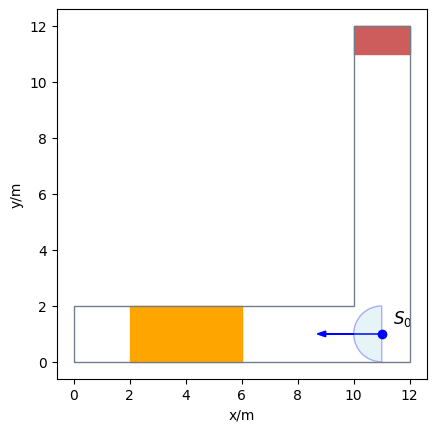

In [4]:
sign_vision_radius = 1
plot_simulation_configuration(
    walkable_area,
    spawning_area,
    exit_areas=exit_polygons,
    vision_radius=sign_vision_radius,
    sign_fov_angle=np.pi,
    sign_points=sign_points,
    sign_orientations=sign_orientations
)

In [5]:
mass = 1
damping = 1
params = ForceParameters(
    a=1.2,
    wall_distance=1,
    wall_strength_always=3.,
    wall_strength_into=4.,
    exit_strength=1,
    exit_domain_radius = 20.0,
    q1=0,
    q2=0., # q2< q1
    eta_mem=0.4,
    eta_sign=2,
    hi=1,
    cutoff_hi=30,
    sign_vision_radius= sign_vision_radius,
    fov_angle= np.pi * 2 / 3,  # 120 degrees
)
steps = 200
num_agents = 2

dt = 0.01
pos_panic=[0, 1]

In [ ]:

c1params = C1Parameters(
    cn0=-0.5,
    cr0= 1.0,
    beta = 0.5,
    nu= 1.0,
    gamma = 2.0,
    epsilon = 3.0)

h1params = H1Parameters(
    hr0 =1.0,
    lam = 1.5,
    sigma = 2.5,
)
c2h2params =  C2H2Parameters(
    phi1= np.pi / 6,
    phi2 = np.pi / 3,
    phi3 = 2 * np.pi / 3,
    phi4= 5 * np.pi / 6,
    cphi1 = 1.0,
    cphi2 = 0.5,
    hphi1 = 1.0,
    hphi2 = 0.5,)

In [6]:
# Run simulation
distribution = spawning_area
walls = extract_walls_from_geometry(area)
exits = exit_polygons
positions = jps.distribute_by_number(
    polygon=Polygon(distribution),
    number_of_agents=num_agents,
    distance_to_agents=0.4,
    distance_to_polygon=0.2,
)
positions[0] = (5, y/2)
positions[1] = positions[0] + np.array([2, 0])
agents = []
for idx, position in enumerate(positions):
    agent = Agent(
        position=position,
        agent_id=idx,
        velocity=[1.0, 0.0],
        mass=mass,
        damping=damping,
        params=params,
    )
    agents.append(agent)

active_agents = list(range(len(agents)))  # keep track of active agent indices

sign_position_orientation = [
    (position, orientation)
    for position, orientation in zip(sign_points, sign_orientations)
]
# Simulation
trajectories = []
for frame in range(steps):
    # Store next state separately to avoid updates affecting other agents' inputs
    next_positions = []
    next_velocities = []
    # for agent1 in agents: calculate the influnce of all other agents
    print(f"{frame = }", end="\r")
    for i in active_agents:
        agent = agents[i]
        # Gather others (positions and velocities)
        others = [(agents[j].x, agents[j].v) for j in active_agents if j != i]

        # Compute forces and update
        agent.compute_forces(
            others,
            walls,
            signs=sign_position_orientation,
            exits=exits,
            x_panic=pos_panic,
        )
        if agent.id !=1:
           agent.update(dt)

        o = normalize(agent.v)
        trajectories.append(
            {
                "frame": frame,
                "id": i,
                "x": agent.x[0],
                "y": agent.x[1],
                "ox": o[0],
                "oy": o[1],
            }
        )

    # Remove agents who have reached the exit
    still_active = []
    for i in active_agents:
        if not any(Point(agents[i].x).within(exit) for exit in exits):
            still_active.append(i)


    active_agents = still_active

    # Stop early if all agents are done
    if not active_agents:
        break
# Convert to DataFrame
df = pd.DataFrame(trajectories)

<Axes: xlabel='x/m', ylabel='y/m'>

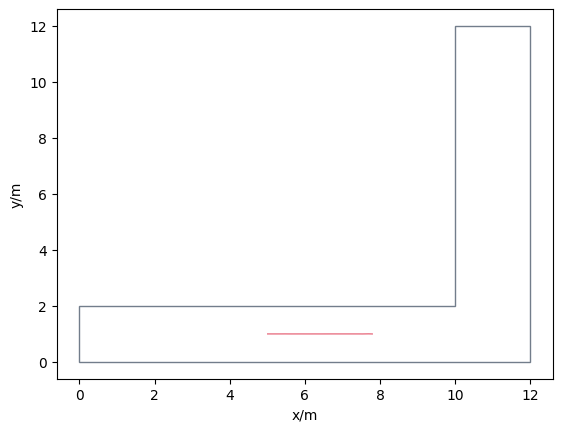

In [7]:
traj = pedpy.TrajectoryData(data=df, frame_rate=1/dt)
walkable_area = pedpy.WalkableArea(polygon=area)
pedpy.plot_trajectories(walkable_area=walkable_area, traj=traj)

In [8]:
animate(data=traj, area=walkable_area, every_nth_frame=1, title_note="Hirai & Tarui, 1975")